In [1]:
import configparser
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import subprocess
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_")

import config_readwrite as crw
import fet

# get plotting scripts

In [2]:
import plot_params as pp

pp.fonts()  # load font parameters
summary_labels = pp.summary_labels()  # get categorical labels for activity codes

# load config 

In [4]:
name = os.path.join("/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/", "config")
config_, config_name_ = crw.read_config(name)

FILE = config_["REPEATMASKER"]["te_data_hg38"]
PATH = config_["REPEATMASKER"]["path"]
ACTIVITY =config_["CIS_TRANS"]["regions_annotations"] ## human shared accessibility regions
RE = config_["REPEATMASKER"]["results"]
REGIONS_X_TE = config_["REPEATMASKER"]["hh_regions_x_te"]  # write
REGIONS_X_TE_OR = config_["REPEATMASKER"]["hh_regions_OR"]  # write

# functions

In [6]:
"""
Add TE overlap - boolean column
"""
def add_te_binary_col(df):
    df["te_bin"] = False
    df.loc[df["te_count-hg38"] >0, "te_bin"] = True
    
    return df

In [7]:
def plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, order):
    fig, ax = plt.subplots(figsize=(6,6))
    
    # get difference between y and upper/lower CI for plotting. 
    l = np.array(data[y]-data[ci_lower])
    u = np.array(data[ci_upper]- data[y])
             
    yerr = [l, u]

    sns.barplot(
            x=x, y=y, data=data,
            #hue = hue,
            linewidth=2.5, 
            order = order,
            #facecolor=(1, 1, 1, 0),
            edgecolor=".2",
            yerr=yerr
            )
   
    plt.axhline(0, color = "grey", linewidth = 2.5)  # plot a line at zero


    #ax.set_xticklabels(["Complex\nEnhancer", "Simple\nEnhancer", "Complex\nEnhancer\nCore v. Derived"])

    ax.set_xlabel("")

    #ax.get_yaxis().ticker.LogLocator(base=2)

    # set the y ticks
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(2**x))
    ax.yaxis.set_major_formatter(ticks)
    ax.yaxis.set_major_locator(MultipleLocator(ytick_multiple))
    ax.set(
        xlabel = "",
        ylabel="Odds ratio, log2-scaled",  # y label
        title = title,
        ylim=ylim)
    return fig, ax

def annotate_bar(graph, ax, annot, height):

    if ax == "x":
    
        for p, a in zip(graph.patches, annot):

            graph.annotate(a, 
                            (p.get_x() + p.get_width() / 2.0, height),
                            #p.get_height()-1), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

# import TE data from config

In [8]:
df_ = pd.read_csv(FILE, sep = '\t')  # 3665778 TABLE, # TABLE MERGED3971065
print(df_.shape)
df_ = add_te_binary_col(df_)
df_["shuf"] = False
df_.head()

(17604, 7)


,#chr,start,end,region_id,te_count-hg38,te,te_fam,te_bin,shuf
0,chr1,959034,959154,chr1:959034-959154,0,['.'],['-1'],False,False
1,chr1,1002089,1002179,chr1:1002089-1002179,0,['.'],['-1'],False,False
2,chr1,1064140,1064260,chr1:1064140-1064260,1,['(CCTGG)n'],['Simple_repeat'],True,False
3,chr1,1214948,1215208,chr1:1214948-1215208,1,['MLT1B'],['LTR/ERVL-MaLR'],True,False
4,chr1,1215328,1215508,chr1:1215328-1215508,0,['.'],['-1'],False,False


## import annotations table

In [9]:
table = pd.read_csv(ACTIVITY, sep = '\t')  # 3665778 TABLE, # TABLE MERGED3971065
print(table.shape)
table.head()

(17604, 26)


,#chr,start,end,region_id,conserved_active.regions,cis,trans,trans_only,cis_only,cis+trans,...,HH-active_MM-inactive_MH-inactive_cis,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans
0,chr1,959034,959154,chr1:959034-959154,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,chr1,1002089,1002179,chr1:1002089-1002179,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,chr1,1064140,1064260,chr1:1064140-1064260,0.0,1.0,0.0,0,1,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr1,1214948,1215208,chr1:1214948-1215208,0.0,1.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,chr1,1215328,1215508,chr1:1215328-1215508,0.0,1.0,0.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


# load shuffles

In [10]:
shuf_dict = {}
shufs = glob.glob(os.path.join(PATH, "shuf-all_uniq_diffAct_regions2-*_TE-cleaned.bed"))
for i, shuf in enumerate(shufs):
    shuf_df = pd.read_csv(shuf, sep = '\t')
    shuf_df= add_te_binary_col(shuf_df)
    shuf_df["shuf"] = True
    shuf_dict[i] = shuf_df
shufs = pd.concat(shuf_dict.values())

print(shufs.shape)
shufs.head()

(158436, 9)


,#chr,start,end,region_id,te_count-hg38,te,te_fam,te_bin,shuf
0,chr1,1032860,1033020,chr11:119752443-119752603,0,['.'],['-1'],False,True
1,chr1,1372063,1372183,chr8:141119858-141119978,0,['.'],['-1'],False,True
2,chr1,1372429,1372849,chr1:154406987-154407407,1,['AluSx1'],['SINE/Alu'],True,True
3,chr1,1399910,1400160,chr3:122416073-122416323,0,['.'],['-1'],False,True
4,chr1,1602518,1602618,chr5:139560656-139560756,1,['GA-rich'],['Low_complexity'],True,True


# how many regions overlap N TEs?

## te_count-hg38
- 0    1659882  # 82% of regions do not overlap TEs. 
- 1     359226  # 18% of regions overlap 1 TE
- 2       9141  # 0.5% of regions overlap 2 TEs
- 3         55  #

In [11]:
df_.groupby("te_bin")["region_id"].count(), df_.groupby("te_bin")["region_id"].count()/df_.shape[0]

(te_bin
 False    13402
 True      4202
 Name: region_id, dtype: int64,
 te_bin
 False    0.761304
 True     0.238696
 Name: region_id, dtype: float64)

# merge TE and table data together 
- inner join so that only shared acc peaks are included
- reassign cis.regions/trans.regions label to distinguish from cis+trans downstream

In [12]:
df = pd.merge(df_, table)

print(df.shape)
df.loc[df["cis+trans"] ==1, ["cis.regions", "trans.regions"]] =0
df.head()

(17604, 31)


,#chr,start,end,region_id,te_count-hg38,te,te_fam,te_bin,shuf,conserved_active.regions,...,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans,cis.regions,trans.regions
0,chr1,959034,959154,chr1:959034-959154,0,['.'],['-1'],False,False,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr1,1002089,1002179,chr1:1002089-1002179,0,['.'],['-1'],False,False,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr1,1064140,1064260,chr1:1064140-1064260,1,['(CCTGG)n'],['Simple_repeat'],True,False,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,chr1,1214948,1215208,chr1:1214948-1215208,1,['MLT1B'],['LTR/ERVL-MaLR'],True,False,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,chr1,1215328,1215508,chr1:1215328-1215508,0,['.'],['-1'],False,False,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN


# pie charts

In [13]:
keep_cols = [ "te_bin", "region_id",]
# get HH elements w/ TE, not Null_0000
HH_TE = df[keep_cols].drop_duplicates()
SHUF_TE = shufs[keep_cols]
HH_TE.shape, SHUF_TE.shape

((17604, 2), (158436, 2))

## percent TE in all regions

   te_bin  region_id
0   False      13402
1    True       4202 

sum te_bin           1
region_id    17604
dtype: int64


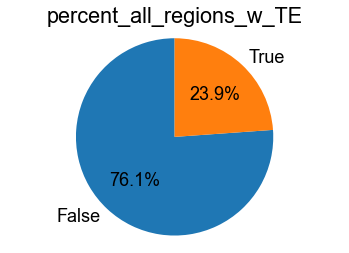

In [14]:
label = "te_bin"  # what % do you want to measure
size = "region_id"  # what col you will use to count the %
data = HH_TE
title = "percent_all_regions_w_TE"
f = pp.plot_pie(data, label, size, title)
out = os.path.join(RE, "pie_chart_active_region_TE.pdf")
plt.savefig(out)

   te_bin  region_id
0   False      99407
1    True      59029 

sum te_bin            1
region_id    158436
dtype: int64


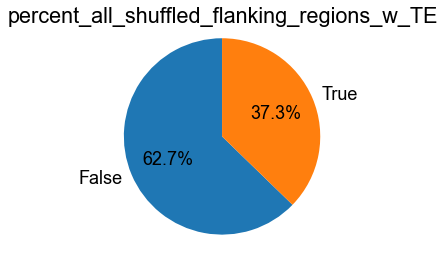

In [15]:
label = "te_bin"  # what % do you want to measure
size = "region_id"  # what col you will use to count the %
data = SHUF_TE
title = "percent_all_shuffled_flanking_regions_w_TE"
pp.plot_pie(data, label, size, title)
out = os.path.join(RE, "pie_chart_shuffled_region_TE.pdf")
plt.savefig(out)

In [17]:
SHUF_TE.head()

,te_bin,region_id
0,False,chr11:119752443-119752603
1,False,chr8:141119858-141119978
2,True,chr1:154406987-154407407
3,False,chr3:122416073-122416323
4,True,chr5:139560656-139560756


##### HH open chromatin does not overlap w/ TE often.

# among human active sequences, are some divergent categories more enriched than others for TE overlap?

## OR category v. shuffled TE overlap 

In [23]:
table.head()

,#chr,start,end,region_id,conserved_active.regions,cis,trans,trans_only,cis_only,cis+trans,...,HH-active_MM-inactive_MH-inactive_cis,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans
0,chr1,959034,959154,chr1:959034-959154,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,chr1,1002089,1002179,chr1:1002089-1002179,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,chr1,1064140,1064260,chr1:1064140-1064260,0.0,1.0,0.0,0,1,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr1,1214948,1215208,chr1:1214948-1215208,0.0,1.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,chr1,1215328,1215508,chr1:1215328-1215508,0.0,1.0,0.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [24]:
col = "cis_only"
ids = set(table.loc[table[col]==1, "region_id"])

In [30]:
test = df.loc[df["region_id"].isin(ids), ["te_bin",col, "region_id"]]
test.groupby(["te_bin",col])["region_id"].describe()

,,count,unique,top,freq
te_bin,cis_only,,,,
False,1,1605,1605,chr12:123076811-123076981,1
True,1,453,453,chr15:40048146-40048256,1


In [34]:
test = shufs.loc[shufs["region_id"].isin(ids), ["te_bin", "region_id"]]
test.groupby(["te_bin"])["region_id"].describe()

,count,unique,top,freq
te_bin,,,,
False,11466,2058,chr17:8118968-8119058,9
True,7056,2002,chr9:7121102-7121292,8


In [35]:
"""
2x2 set up - All human active (1xxx) regions.

"cis_only", "trans_only", "cons_act", "cis+trans"

Hypothesis - cis_only is enriched for TEs compared to length-matched 10x shuffled categories. 

                TE - True    TE - False
     cis_only - True    A      |    B
shuf cis_only - False   C      |    D

"""

cols = [
            "conserved_active.regions", 
        'trans_only',
        'cis_only',     
        "cis+trans",
        'HH-active_MM-inactive_trans-only',
        'HH-active_MM-inactive_cis-only',
        'HH-active_MM-inactive_cis+trans',
        'MM-active_HH-inactive_cis-only',
        'MM-active_HH-inactive_trans-only',
        'MM-active_HH-inactive_cis+trans',

]

cat_results = {}
data = df
for col in cols:
    print(col)
    
    ids = set(table.loc[table[col]==1, "region_id"])
    
    test = df.loc[df["region_id"].isin(ids), ["te_bin", col, "region_id"]]
    test = test.groupby(["te_bin",col])["region_id"].describe().reset_index()

    a = test.loc[(test["te_bin"]== True) & (test[col]== 1), "count"].iloc[0]
    b = test.loc[(test["te_bin"]== False) & (test[col]== 1), "count"].iloc[0]

    # get the counts of TE overlaps (c) and non-overlaps (d) in other columns
    not_test = shufs.loc[shufs["region_id"].isin(ids), ["te_bin", "region_id"]]
    not_test = not_test.groupby("te_bin")["region_id"].describe().reset_index()
    c = not_test.loc[not_test["te_bin"]== True, "count"].iloc[0]
    d = not_test.loc[not_test["te_bin"]== False, "count"].iloc[0]
    print([[a,b],[c,d]])

    fet_results = fet.get_2x2(a,b,c,d, f"{col}-activity_x_te")
    fet_results["col"] = col
    cat_results[col] = fet_results


fdr_fet = fet.fdr_correction(cat_results)  # do FDR correction
fdr_fet["frac"] = fdr_fet["a"]/ (fdr_fet["a"]+ fdr_fet["b"])

conserved_active.regions
[[514, 1883], [9393, 12180]]
[[514, 1883], [9393, 12180]]
conserved_active.regions-activity_x_te [[514, 1883], [9393, 12180]] 0.35396128652318404 1.2946600248128052e-103
trans_only
[[445, 1602], [7014, 11409]]
[[445, 1602], [7014, 11409]]
trans_only-activity_x_te [[445, 1602], [7014, 11409]] 0.45183442638532456 2.1429802671218905e-51
cis_only
[[453, 1605], [7056, 11466]]
[[453, 1605], [7056, 11466]]
cis_only-activity_x_te [[453, 1605], [7056, 11466]] 0.4586448598130841 5.63649381764794e-50
cis+trans
[[2589, 7587], [32141, 59443]]
[[2589, 7587], [32141, 59443]]
cis+trans-activity_x_te [[2589, 7587], [32141, 59443]] 0.6311074415348277 3.7389394241204176e-88
HH-active_MM-inactive_trans-only
[[187, 604], [2622, 4497]]
[[187, 604], [2622, 4497]]
HH-active_MM-inactive_trans-only-activity_x_te [[187, 604], [2622, 4497]] 0.5310004243260036 4.2371520722259365e-14
HH-active_MM-inactive_cis-only
[[193, 881], [3690, 5976]]
[[193, 881], [3690, 5976]]
HH-active_MM-inactive_c

In [38]:
plot_sets = {
            "global":
                [ "conserved_active.regions", 
                 'trans_only','cis_only', "cis+trans"],
            "figure":
                [ #"conserved_active.regions", 
                 'trans_only','cis_only', "cis+trans"],
            
            "HH-active_MM-inactive":
                ['HH-active_MM-inactive_trans-only','HH-active_MM-inactive_cis-only','HH-active_MM-inactive_cis+trans'],
            "MM-active_HH-inactive":
                ['MM-active_HH-inactive_trans-only','MM-active_HH-inactive_cis-only','MM-active_HH-inactive_cis+trans']
            }

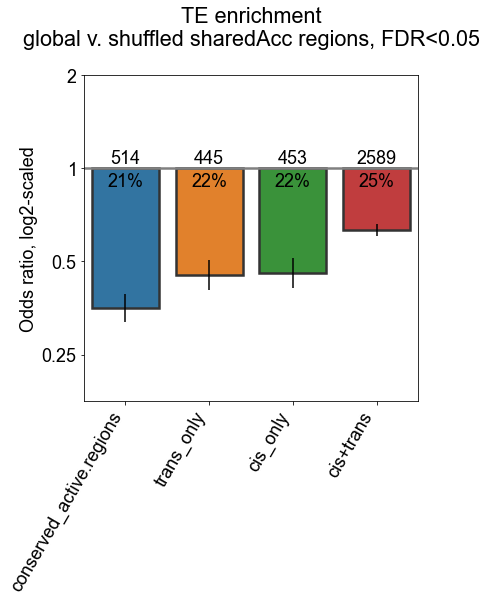

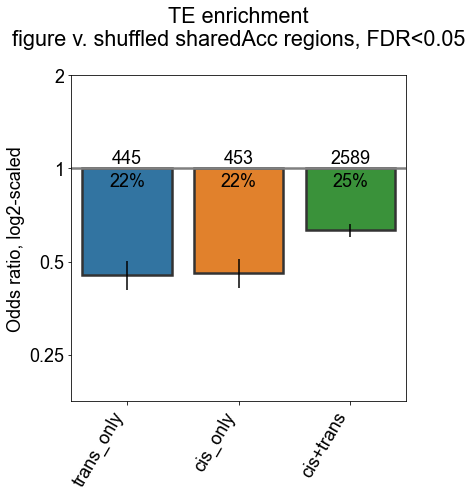

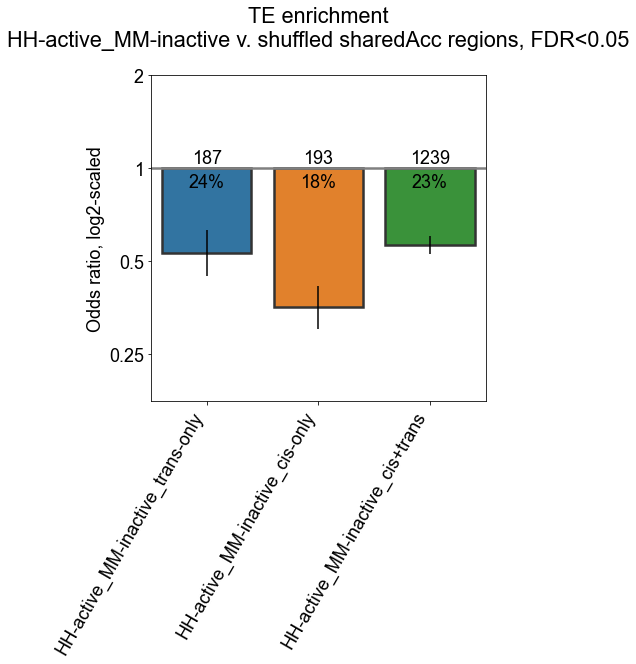

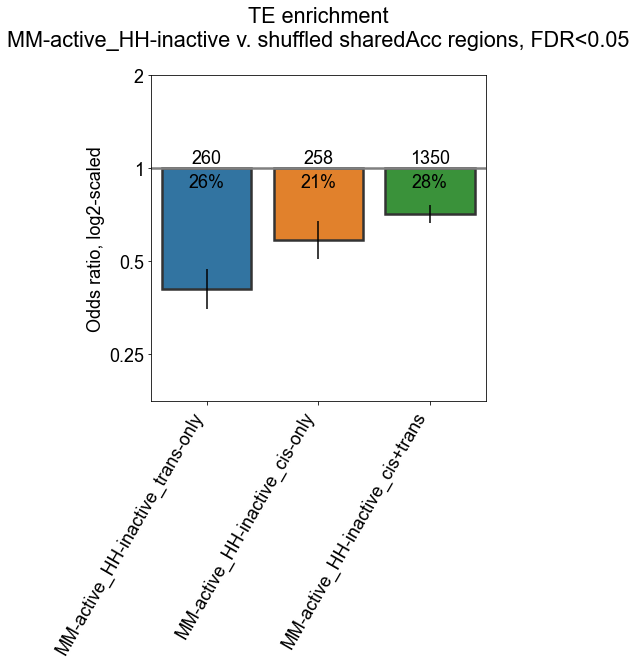

In [39]:
# plot OR
for key in plot_sets.keys():
    order = plot_sets[key]
    x = "col"
    y = "OR_log2"
    data = fdr_fet.loc[fdr_fet['col'].isin(order)]
    ci_upper, ci_lower = "ci_upper_log2", "ci_lower_log2"
    ytick_multiple = 1
    ylim =(-2.5,1) # log2 coordinates

    title = f"TE enrichment\n{key} v. shuffled sharedAcc regions, FDR<0.05\n"
    hue = None

    fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, order)

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")

    annotate_bar(ax, "x", list(data['a']), 0.05)
    annotate_bar(ax, "x", list(data["frac"].round(2).apply(lambda x: str(x*100).split(".")[0]+ "%")), -0.2)
    outf = os.path.join(RE, f"SharedACC_HH_isActive_TE_OR_Regions-{key}_v2.pdf")
    plt.savefig(outf, bbox_inches = "tight")

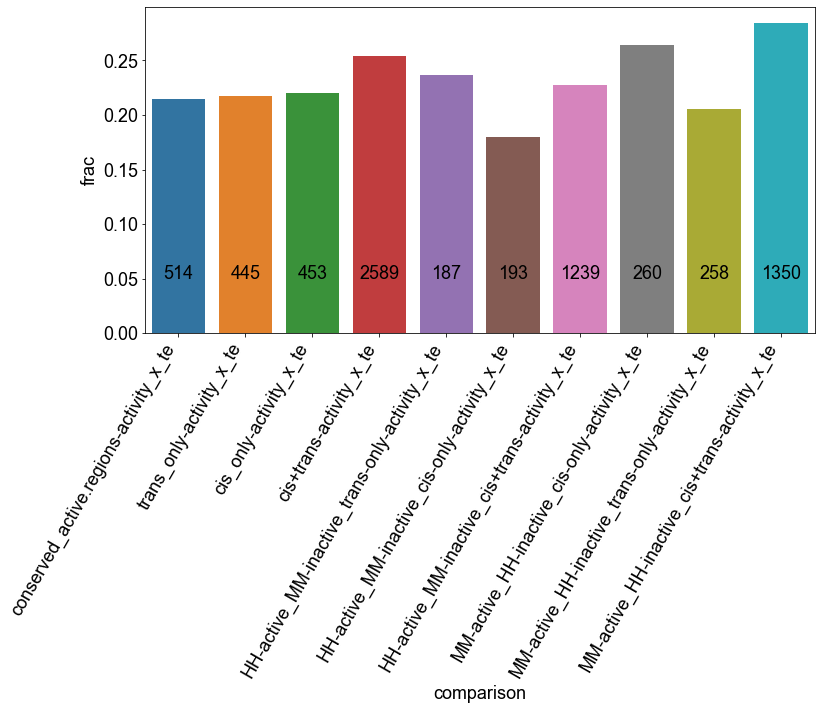

In [40]:
x = "comparison"
y = "frac"
data = fdr_fet
fig, (ax1) = plt.subplots(ncols = 1, figsize = (12,6))
sns.barplot(x=x,y=y, data=data, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 60, horizontalalignment = "right")
annotate_bar(ax1, "x", list(fdr_fet["a"]), 0.05)

outf = os.path.join(RE, "SharedACC_HH_isActive_TE_N_regions_v2.pdf")
plt.savefig(outf, bbox_inches = "tight")

## category v. not category

In [99]:
"""
2x2 set up - All human active (1xxx) regions.

"cis_only", "trans_only", "cons_act", "cis+trans"

Hypothesis - cis_only is enriched for TEs compared to all other divergence categories. 

                TE - True    TE - False
cis_only - True    A      |    B
cis_only - False   C      |    D

"""

cat_results = {}
data = df
for col in cols:
    print(col)
    test = data.groupby(["te_bin",col])["region_id"].describe().reset_index()

    a = test.loc[(test["te_bin"]== True) & (test[col]== 1), "count"].iloc[0]
    b = test.loc[(test["te_bin"]== False) & (test[col]== 1), "count"].iloc[0]

    # get the counts of TE overlaps (c) and non-overlaps (d) in other columns
    not_test = shufs.groupby("te_bin")["region_id"].describe().reset_index()
    c = test.loc[(test["te_bin"]== True) & (test[col]== 0), "count"].iloc[0]
    d = test.loc[(test["te_bin"]== False) & (test[col]== 0), "count"].iloc[0]
    print([[a,b],[c,d]])

    fet_results = fet.get_2x2(a,b,c,d, f"{col}-activity_x_te")
    fet_results["col"] = col
    cat_results[col] = fet_results


fdr_fet = fet.fdr_correction(cat_results)  # do FDR correction
fdr_fet["frac"] = fdr_fet["a"]/ (fdr_fet["a"]+ fdr_fet["b"])

conserved_active.regions
[[514, 1883], [3688, 11519]]
[[514, 1883], [3688, 11519]]
conserved_active.regions-activity_x_te [[514, 1883], [3688, 11519]] 0.8525829922482585 0.002561168170083165
trans_only
[[445, 1602], [3757, 11800]]
[[445, 1602], [3757, 11800]]
trans_only-activity_x_te [[445, 1602], [3757, 11800]] 0.8724455091237098 0.016407975873382993
cis_only
[[453, 1605], [3749, 11797]]
[[453, 1605], [3749, 11797]]
cis_only-activity_x_te [[453, 1605], [3749, 11797]] 0.8881356523733431 0.03649810893371272
cis+trans
[[2589, 7587], [1613, 5815]]
[[2589, 7587], [1613, 5815]]
cis+trans-activity_x_te [[2589, 7587], [1613, 5815]] 1.2302045190851223 1.0030118397933563e-08
HH-active_MM-inactive_trans-only
[[187, 604], [4015, 12798]]
[[187, 604], [4015, 12798]]
HH-active_MM-inactive_trans-only-activity_x_te [[187, 604], [4015, 12798]] 0.9868729021137621 0.8981955677709544
HH-active_MM-inactive_cis-only
[[193, 881], [4009, 12521]]
[[193, 881], [4009, 12521]]
HH-active_MM-inactive_cis-only-activ

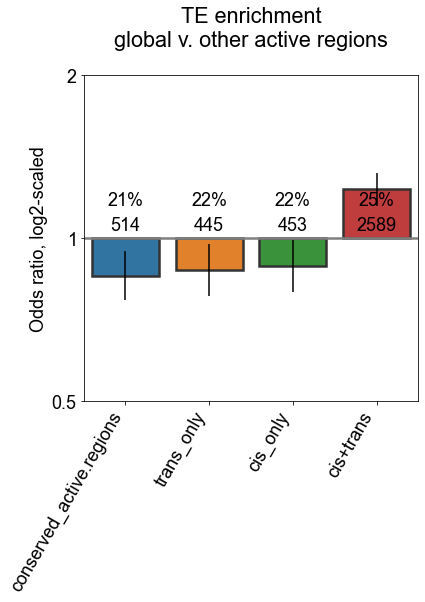

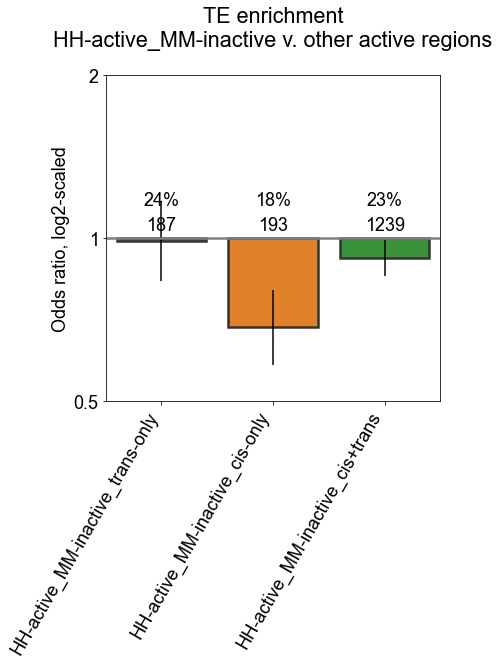

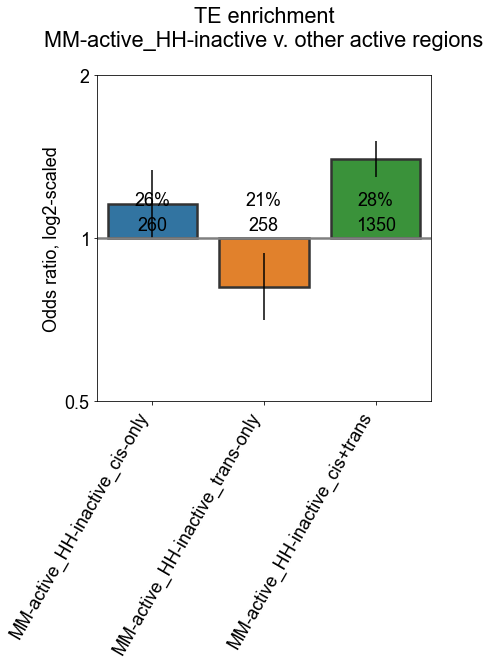

In [105]:
# plot OR
for key in plot_sets.keys():
    order = plot_sets[key]
    x = "col"
    y = "OR_log2"
    data = fdr_fet.loc[fdr_fet['col'].isin(order)]
    ci_upper, ci_lower = "ci_upper_log2", "ci_lower_log2"
    ytick_multiple = 1
    ylim =(-1,1) # log2 coordinates

    title = f"TE enrichment\n{key} v. other active regions\n"
    hue = None

    fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, order)

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")

    annotate_bar(ax, "x", list(data['a']), 0.05)
    annotate_bar(ax, "x", list(data["frac"].round(2).apply(lambda x: str(x*100).split(".")[0]+ "%")), 0.2)
    outf = os.path.join(RE, f"SharedACC_HH_isActive_TE_OR_Regions_vothers-{key}_v2.pdf")
#    plt.savefig(outf, bbox_inches = "tight")

2x2


                    TE True      TE False


    Category True     A.           B


    Category False    C.           D

# TE enrichment in elements 


- TE must overlap at least 500 regions to be considered. 

In [42]:
def test_te_enrichment(col, t, df):
    ###
    #DEV
    ###
    #                     TE overlap -True    TE overlap -False

    # cis.regions -True    A                          B  
    # cis.regions -Flase   C                          D

    """
    1. for single te, for single test regulatory category
    2. get all the regions that overlap that TE. 
    3. get all regions in test category
    4. get all regions not in category and subtract any regions that overlap the test category
    5. count test category regions overlapping TE
    6. count all test category regions NOT overlapping TE
    7. count NOT test category regions overlapping TE
    8. count NOT test category regions NOT overlapping TE
    9. if there are at least 50 TE instances in dataset, calculate FET enrichment

    """
    #t = "Alu"
    #col = "cis+trans"

    #1
    test = df.loc[df["shuf"]==False]

    #2
    TE_true_regions = set(test.loc[(test["te"].str.contains(t)), "region_id"])  # get all the regions w/ TE

    blank = pd.DataFrame({col:[True, False]})

    #3
    col_true_regions = set(test.loc[test[col] ==1, "region_id"])

    #4
    col_false_regions = set(test.loc[test[col] ==0, "region_id"])
    col_false_regions = col_false_regions.difference(col_true_regions)

    #5
    a = len(TE_true_regions.intersection(col_true_regions))
    #6
    b = len(col_true_regions.difference(TE_true_regions))
    #7
    c = len(TE_true_regions.intersection(col_false_regions))
    #8
    d = len(col_false_regions.difference(TE_true_regions))
    #print(a,b, c,d)

    if a + c >50:
        comparison = f"{col}_x_{t}"
        #5
        fet_results = fet.get_2x2(a,b,c,d, comparison)
        fet_results["te"] = t
        fet_results["activity_cat"] = col
        
    else:
        fet_results = pd.DataFrame()
    
    return fet_results

## make a list of TEs to test

In [43]:
tested_tes = []
for te in df.te.unique():
    for t in te.split(" "):
        if t not in tested_tes:
            t_ = str(t.strip("[]")).strip("''")
            tested_tes.append(t_)


tested_tes[1]

'(CCTGG)n'

## unit test for one TE enrichment. 

In [29]:
###
#DEV
###
#                     TE overlap -True    TE overlap -False

# cis.regions -True    A                          B  
# cis.regions -Flase   C                          D

"""
1. for single te, for single test regulatory category
2. get all the regions that overlap that TE. 
3. get all regions in test category
4. get all regions not in category and subtract any regions that overlap the test category
5. count test category regions overlapping TE
6. count all test category regions NOT overlapping TE
7. count NOT test category regions overlapping TE
8. count NOT test category regions NOT overlapping TE
9. if there are at least 50 TE instances in dataset, calculate FET enrichment

"""
t = "Alu"
col = "cis+trans"
#col = "cis.regions"

comparison = f"{t}_x_{col}"
#1
test = df.loc[df["shuf"]==False]

#2
TE_true_regions = set(test.loc[(test["te"].str.contains(t)), "region_id"])  # get all the regions w/ TE

blank = pd.DataFrame({col:[True, False]})

#3
col_true_regions = set(test.loc[test[col] ==1, "region_id"])

#4
col_false_regions = set(test.loc[test[col] ==0, "region_id"])
col_false_regions = col_false_regions.difference(col_true_regions)

#5
a = len(TE_true_regions.intersection(col_true_regions))
#6
b = len(col_true_regions.difference(TE_true_regions))
#7
c = len(TE_true_regions.intersection(col_false_regions))
#8
d = len(col_false_regions.difference(TE_true_regions))
print(a,b, c,d)

if a + c >50:
    #5
    fet_results = fet.get_2x2(a,b,c,d, comparison)
    fet_results["te"] = t
    fet_results["activity_cat"] = col

375 9801 158 7270
[[375, 9801], [158, 7270]]
Alu_x_cis+trans [[375, 9801], [158, 7270]] 1.7605088088402243 1.5175143307618376e-09


In [45]:
cols = [
            "conserved_active.regions", 
        'trans_only',
        'cis_only',     
        "cis+trans",
        'HH-active_MM-inactive_trans-only',
        'HH-active_MM-inactive_cis-only',
        'HH-active_MM-inactive_cis+trans',
        'MM-active_HH-inactive_cis-only',
        'MM-active_HH-inactive_trans-only',
        'MM-active_HH-inactive_cis+trans',

]

"""
#                     TE overlap -True    TE overlap -False

# cis.regions -True    A                          B  
# cis.regions -Flase   C                          D


1. for single te, for single test regulatory category
2. get all the regions that overlap that TE. 
3. get all regions in test category
4. get all regions not in category and subtract any regions that overlap the test category
5. count test category regions overlapping TE
6. count all test category regions NOT overlapping TE
7. count NOT test category regions overlapping TE
8. count NOT test category regions NOT overlapping TE
9. if there are at least 50 TE instances in dataset, calculate FET enrichment
10. add to dictionary. 
11. FDR correct per test category (e.g. trans only)

"""
outf = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/repeatmasker/HH_activity_code_OR_all_regions_v2.tsv"
if os.path.exists(outf) is False:
    col_results = {}
    for col in cols:
        print(col)

        blank = pd.DataFrame({col:[True, False]})
        te_col = {}

        if col not in col_results.keys():

            for t in set(tested_tes[1:]):
                results = test_te_enrichment(col, t, df)

                if True in set(results.any()):
                    te_col[t] = results
                    #print(type(results), cols)
                else:
                    continue

        #11
        fdr_results = fet.fdr_correction(te_col)
        col_results[col] = fdr_results

    all_te_enrichment = pd.concat(col_results.values())

    all_te_enrichment.to_csv(outf, sep = '\t', index = False)
else:
    all_te_enrichment = pd.read_csv(outf, sep = '\t')

In [47]:
col_results["cis+trans"]

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,OR_log2,ci_lower_log2,ci_upper_log2,comparison,te,activity_cat,reject_null,FDR_P,asterisks,-log10p
0,29,10147,36,7392,0.586840,3.283368e-02,0.359525,0.706876,0.957879,0.706876,-0.768961,-1.475836,-0.062085,cis+trans_x_GA-rich,GA-rich,cis+trans,False,5.303902e-02,None,1.275404
0,45,10131,41,7387,0.800285,3.252539e-01,0.523612,0.612014,1.223148,0.612014,-0.321415,-0.933429,0.290599,cis+trans_x_L3,L3,cis+trans,False,3.794629e-01,None,0.420831
0,108,10068,36,7392,2.202622,1.936705e-05,1.508718,0.545898,3.215673,0.545898,1.139222,0.593324,1.685121,cis+trans_x_AluSx,AluSx,cis+trans,True,1.355694e-04,*,3.867838
0,44,10132,22,7406,1.461903,1.695285e-01,0.875538,0.739605,2.440967,0.739605,0.547847,-0.191758,1.287453,cis+trans_x_MIR1_Amn,MIR1_Amn,cis+trans,False,2.225061e-01,None,0.652658
0,42,10134,30,7398,1.022025,1.000000e+00,0.639101,0.677315,1.634382,0.677315,0.031430,-0.645884,0.708745,cis+trans_x_LTR1,LTR1,cis+trans,False,1.000000e+00,None,-0.000000
0,375,9801,158,7270,1.760509,1.517514e-09,1.458267,0.271738,2.125393,0.271738,0.815992,0.544255,1.087730,cis+trans_x_Alu,Alu,cis+trans,True,3.186780e-08,*,7.496648
0,146,10030,87,7341,1.228253,1.418310e-01,0.940294,0.385425,1.604399,0.385425,0.296608,-0.088817,0.682033,cis+trans_x_MIRc,MIRc,cis+trans,False,1.985634e-01,None,0.702101
0,57,10119,21,7407,1.986828,5.751544e-03,1.203606,0.723104,3.279716,0.723104,0.990467,0.267363,1.713571,cis+trans_x_AluJb,AluJb,cis+trans,True,1.988649e-02,*,1.701442
0,46,10130,35,7393,0.959182,9.103342e-01,0.617352,0.635711,1.490284,0.635711,-0.060123,-0.695834,0.575588,cis+trans_x_AluJr,AluJr,cis+trans,False,9.558509e-01,None,0.019610
0,52,10124,36,7392,1.054656,8.295963e-01,0.688809,0.614596,1.614814,0.614596,0.076772,-0.537824,0.691368,cis+trans_x_MER5A,MER5A,cis+trans,False,9.169222e-01,None,0.037668


In [48]:
for_plotting = ['conserved_active.regions', 'trans_only', 'cis_only','cis+trans', 
               #'HH-active_MM-inactive_cis+trans', 'MM-active_HH-inactive_cis+trans'
               ]

0 0
0 A-rich 0.7776250937942258
1 GA-rich 0.5246795278182677
2 MIRc 0.11787841924822023
3 L2a 0.07444605455762118
4 MER5A 0.002481153612150783
1 0
0 A-rich 1.0405213957827038
1 GA-rich 0.7865818224194286
2 L2c 0.3350888785238071
3 AluJr 0.4044882020639721
4 MER5A 0.2644329534996758
5 LTR1 0.2950166540081772
6 L3 0.15739531576565413
7 L2b 0.02322399256220702
0 1
0 L3 0.14859637203837905
1 MIRb 0.10600267309614934
2 L2d 0.14859637203837905
3 GA-rich 0.08465817492496575
1 1
0 Alu 0.8159924458538778
1 MIR 0.45975730389269803
2 AluSx 1.1392220409762344
3 L2 0.4339345866446041
4 AluJb 0.9904671095106368
5 MIRb 0.37986207451632975
6 MIR3 0.45800467992439026
7 AluSz 0.7646843768348214
8 L2a 0.46231467487639494
9 L2b 0.4805856397409517
10 AluSx1 0.9410484752834842
11 L2d 0.5992991046663716


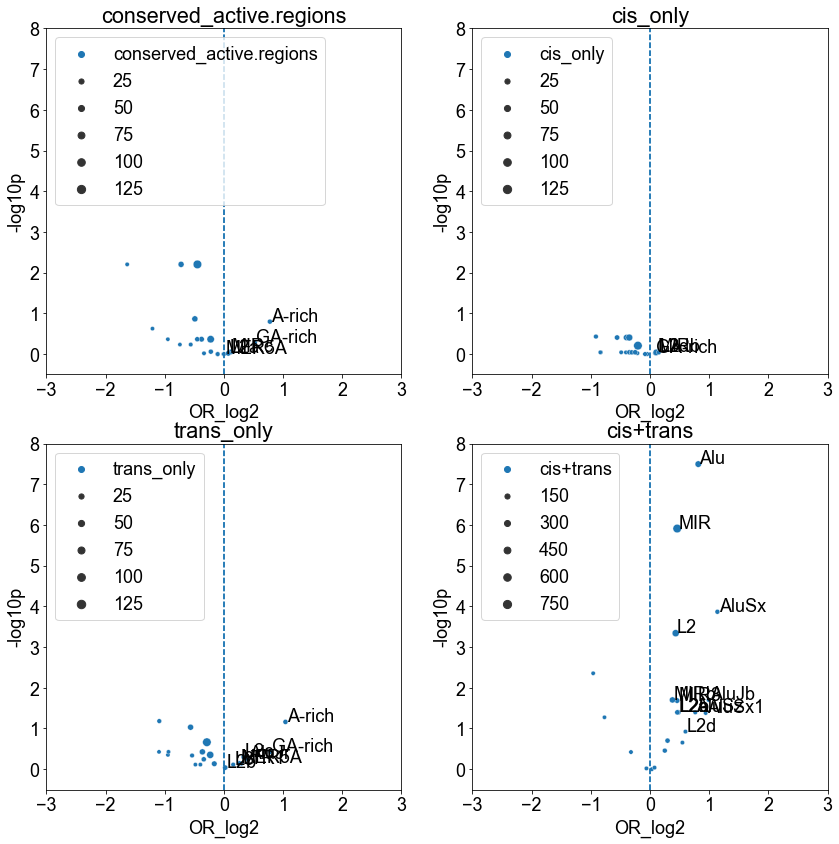

In [75]:
split_at = round(len(col_results.keys())/2, 0)
split_at = round(len(for_plotting)/2, 0)
fig, ax_ = plt.subplots(ncols = 2, nrows = int(split_at), figsize = (14,14))
idxcol, idxrow = 0,0

for key, val in col_results.items():
    if key in for_plotting:

        print(idxrow, idxcol)
        ax = ax_[idxrow][idxcol]
        val['-log10p'] = np.log10(val["FDR_P"])*-1

        x = "OR_log2"
        y = "-log10p"
        hue = "activity_cat"
        data = col_results[key]
        size = list(data["a"])

        #fig, ax = plt.subplots(figsize = (6,6))
        sns.scatterplot(x=x, y=y, data=data, hue=hue, ax=ax, size=size)
        ax.set(title = key)
        ax.axvline(0, ls = "--")

        sig = data.loc[(data[x].astype(float)>0) 
                       #& (data["reject_null"]==True)
                      ].sort_values(by=y, ascending=False)

        # Annotate sign TE label points 
        for i, l in enumerate(sig["te"]):
            print(i, l, sig[x].iloc[i])
            ax.annotate(l, (sig[x].iloc[i]+0.02, sig[y].iloc[i]+0.02) )
            if i >10:
                break
        ax.legend(loc="upper left")#bbox_to_anchor = (1,1))#.remove()
        ax.set(title = key, xlim =(-3,3), ylim=(-0.5,8))
        ax.axvline(0, ls = "--")

        idxrow +=1

        if idxrow ==split_at:
            idxrow = 0
            idxcol = 1

        del data, sig

outf = os.path.join(RE, "SharedACC_HH_isActive_TE_Scatter_OR_regions_all_v2.pdf")
plt.savefig(outf, bbox_inches = "tight")

In [63]:
data = col_results["cis+trans"]
sig = data.loc[(data[x].astype(float)>0)]
sig.sort_values(by=y, ascending=False)

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,OR_log2,ci_lower_log2,ci_upper_log2,comparison,te,activity_cat,reject_null,FDR_P,asterisks,-log10p
0,375,9801,158,7270,1.760509,1.517514e-09,1.458267,0.271738,2.125393,0.271738,0.815992,0.544255,1.087730,cis+trans_x_Alu,Alu,cis+trans,True,3.186780e-08,*,7.496648
0,829,9347,450,6978,1.375310,1.163962e-07,1.221161,0.171504,1.548919,0.171504,0.459757,0.288253,0.631262,cis+trans_x_MIR,MIR,cis+trans,True,1.222160e-06,*,5.912872
0,108,10068,36,7392,2.202622,1.936705e-05,1.508718,0.545898,3.215673,0.545898,1.139222,0.593324,1.685121,cis+trans_x_AluSx,AluSx,cis+trans,True,1.355694e-04,*,3.867838
0,497,9679,272,7156,1.350913,8.666297e-05,1.161637,0.217775,1.571029,0.217775,0.433935,0.216159,0.651710,cis+trans_x_L2,L2,cis+trans,True,4.549806e-04,*,3.342007
0,57,10119,21,7407,1.986828,5.751544e-03,1.203606,0.723104,3.279716,0.723104,0.990467,0.267363,1.713571,cis+trans_x_AluJb,AluJb,cis+trans,True,1.988649e-02,*,1.701442
0,308,9868,174,7254,1.301217,6.628828e-03,1.077851,0.271704,1.570872,0.271704,0.379862,0.108158,0.651566,cis+trans_x_MIRb,MIRb,cis+trans,True,1.988649e-02,*,1.701442
0,204,9972,109,7319,1.373641,7.849759e-03,1.086519,0.338291,1.736637,0.338291,0.458005,0.119713,0.796296,cis+trans_x_MIR3,MIR3,cis+trans,True,2.060562e-02,*,1.686014
0,65,10111,28,7400,1.698998,2.016661e-02,1.089778,0.640650,2.648791,0.640650,0.764684,0.124035,1.405334,cis+trans_x_AluSz,AluSz,cis+trans,True,4.017861e-02,*,1.396005
0,156,10020,83,7345,1.377751,2.082392e-02,1.053872,0.386615,1.801164,0.386615,0.462315,0.075700,0.848929,cis+trans_x_L2a,L2a,cis+trans,True,4.017861e-02,*,1.396005
0,139,10037,73,7355,1.395310,2.104594e-02,1.049405,0.411014,1.855232,0.411014,0.480586,0.069572,0.891600,cis+trans_x_L2b,L2b,cis+trans,True,4.017861e-02,*,1.396005


In [95]:
for_plotting = ['HH-active_MM-inactive_cis+trans',
                'HH-active_MM-inactive_trans-only',
                'HH-active_MM-inactive_cis-only',                
                'MM-active_HH-inactive_cis+trans',
                'MM-active_HH-inactive_trans-only',
                'MM-active_HH-inactive_cis-only',
                ]

# scatterplot for HH, MM

0 0
0 Alu 0.5126594852609183
1 AluSx 0.8485041885436321
1 0
0 A-rich 1.5663443344414563
2 0
0 1
0 MIR1_Amn 1.3584532500423523
1 Alu 0.3440001620856802
2 MIRc 0.7301612503588146
3 L2 0.6245942876140917
4 MIR3 0.789466366796768
5 L2a 0.5374781319983881
6 L2d 0.7605579149858189
7 L2b 0.6383369907746218
8 MIR 0.7610118997002688
9 MIRb 0.5676506448605845
1 1
2 1


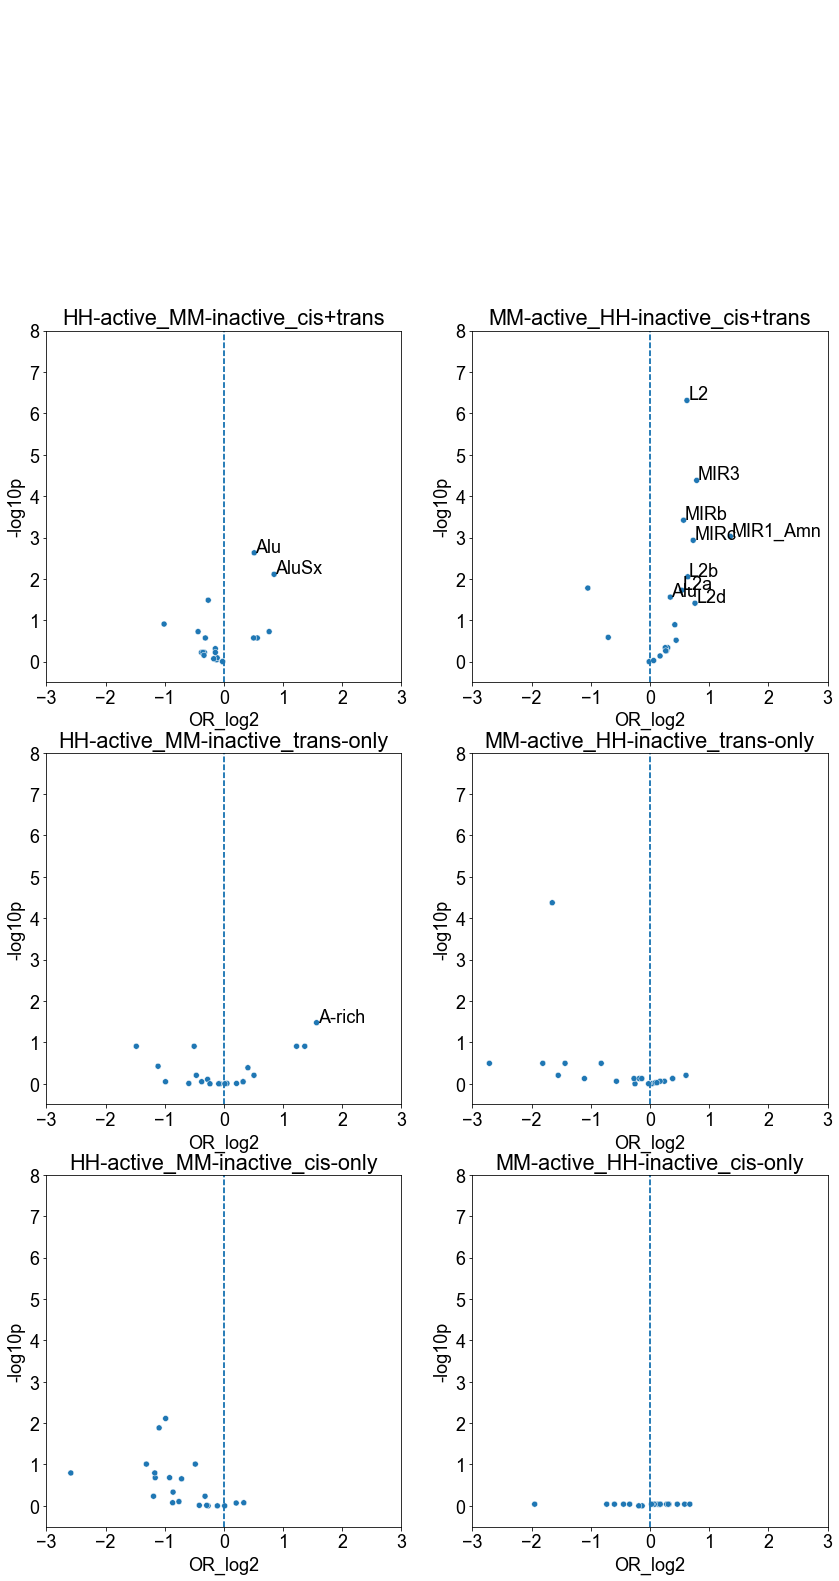

In [96]:
split_at = round(len(col_results.keys())/2, 0)
split_at = round(len(for_plotting)/2, 0)
fig, ax_ = plt.subplots(ncols = 2, nrows = int(split_at), figsize = (14,22))
idxcol, idxrow = 0,0

#for key, val in col_results.items():
for key in for_plotting:

    print(idxrow, idxcol)
    ax = ax_[idxrow][idxcol]
    val['-log10p'] = np.log10(val["FDR_P"])*-1

    x = "OR_log2"
    y = "-log10p"
    hue = "activity_cat"
    data = col_results[key]
    size = "a"

    #fig, ax = plt.subplots(figsize = (6,6))
    sns.scatterplot(x=x, y=y, data=data, hue=hue, ax=ax, size=size)
    ax.set(title = key)
    ax.axvline(0, ls = "--")
    
    sig = data.loc[(data[x].astype(float)>0) & (data["reject_null"]==True)]

    # Annotate sign TE label points 
    for i, l in enumerate(sig["te"]):
        print(i, l, sig[x].iloc[i])
        ax.annotate(l, (sig[x].iloc[i]+0.02, sig[y].iloc[i]+0.02) )
    ax.legend(bbox_to_anchor = (1,1)).remove()
    ax.set(title = key, xlim =(-3,3), ylim=(-0.5,8))
    ax.axvline(0, ls = "--")
    
    idxrow +=1

    if idxrow ==split_at:
        idxrow = 0
        idxcol = 1

    del data, sig
    
outf = os.path.join(RE, "SharedACC_HH_isActive_TE_Scatter_OR_regions_HH_v_MM_v2.pdf")
plt.savefig(outf, bbox_inches = "tight")

# save dataframe 

In [66]:
all_te_enrichment = pd.concat(col_results.values())

all_te_enrichment.head()

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,OR_log2,ci_lower_log2,ci_upper_log2,comparison,te,activity_cat,reject_null,FDR_P,asterisks,-log10p
0,12,2385,53,15154,1.438614,0.274097,0.767678,0.906107,2.695936,0.906107,0.524680,-0.381427,1.430786,conserved_active.regions_x_GA-rich,GA-rich,conserved_active.regions,False,0.523276,None,0.281269
0,11,2386,75,15132,0.930159,1.000000,0.493281,0.915068,1.753962,0.915068,-0.104450,-1.019518,0.810617,conserved_active.regions_x_L3,L3,conserved_active.regions,False,1.000000,None,-0.000000
0,7,2390,137,15070,0.322176,0.000893,0.150564,1.097475,0.689391,1.097475,-1.634080,-2.731555,-0.536606,conserved_active.regions_x_AluSx,AluSx,conserved_active.regions,True,0.006254,*,2.203864
0,5,2392,61,15146,0.519011,0.205607,0.208339,1.316831,1.292952,1.316831,-0.946162,-2.262992,0.370669,conserved_active.regions_x_MIR1_Amn,MIR1_Amn,conserved_active.regions,False,0.431775,None,0.364742
0,8,2389,64,15143,0.792329,0.729555,0.379451,1.062187,1.654459,1.062187,-0.335828,-1.398015,0.726359,conserved_active.regions_x_LTR1,LTR1,conserved_active.regions,False,0.957541,None,0.018843


In [67]:
outf = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/repeatmasker/TE_activity_code_OR_all_regions_v2.tsv"
all_te_enrichment.to_csv(outf, sep = '\t', index = False)

# plot all categories together. 

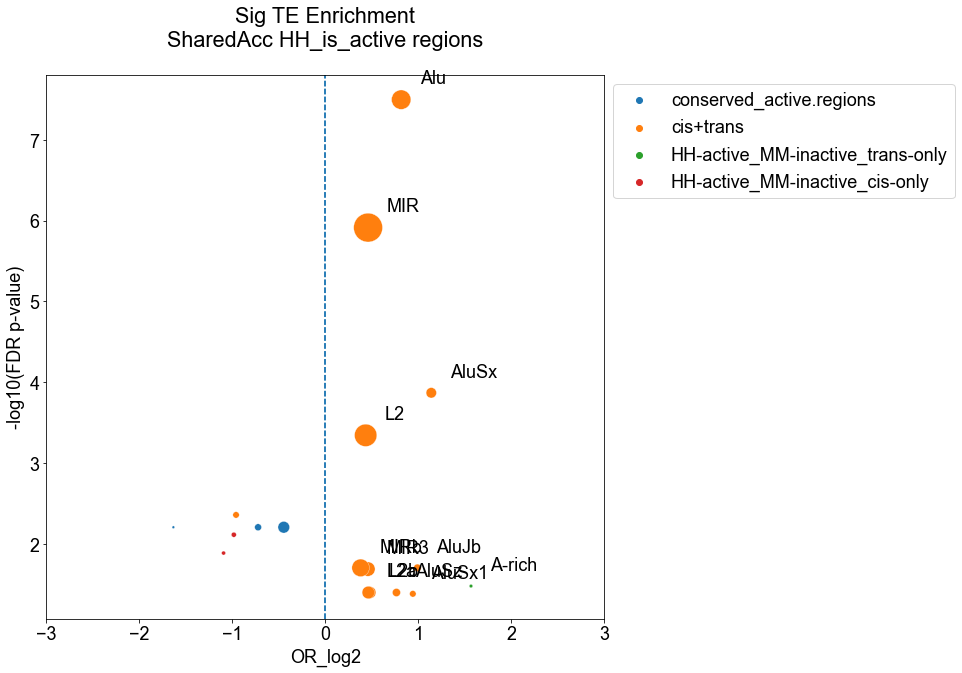

In [71]:
all_te_enrichment['-log10p'] = np.log10(all_te_enrichment["FDR_P"])*-1

x = "OR_log2"
y = "-log10p"
hue = "activity_cat"

data = all_te_enrichment.loc[all_te_enrichment["reject_null"]==True]
size = list(data["a"])

fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(x=x, y=y, data=data, hue=hue, s=size)
ax.set(title = key, xlim=(-3,3))
ax.axvline(0, ls = "--")

sig = data.loc[(data[x].astype(float)>0)]

# Annotate label points 
for i, l in enumerate(sig["te"]):
    #print(i, l, data[x].iloc[i])
    ax.annotate(l, (sig[x].iloc[i]+0.2, sig[y].iloc[i]+0.2) )

ax.legend(bbox_to_anchor = (1,1))

ax.set(title = "Sig TE Enrichment\nSharedAcc HH_is_active regions\n",
      ylabel = "-log10(FDR p-value)")

ax.axvline(0, ls = "--")

outf = os.path.join(RE, "SharedACC_HH_isActive_TE_Scatter_OR_ALL_regions_20220411.pdf")
#plt.savefig(outf, bbox_inches = "tight")

plt.show()

# plot N

In [46]:
all_te_enrichment["te"].unique()

array(['AluJb', 'L2a', 'MIR', 'L3', 'GA-rich', 'L2b', 'MIR1_Amn', 'Alu',
       'A-rich', 'AluJr', 'MIRc', 'MIR3', 'L2d', 'L2', 'MIRb', 'LTR1',
       'AluSz', 'AluSx', 'L2c', 'MER5A', 'AluSx1'], dtype=object)

In [47]:
all_te_enrichment

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,OR_log2,ci_lower_log2,ci_upper_log2,comparison,te,activity_cat,reject_null,FDR_P,asterisks,-log10p
0,5,2392,73,15134,0.433351,0.067751,0.174946,1.308624,1.073433,1.308624,-1.206392,-2.515016,0.102232,conserved_active.regions_x_AluJb,AluJb,conserved_active.regions,False,0.237130,None,0.625014
0,34,2363,205,15002,1.052957,0.775651,0.730579,0.527333,1.517587,0.527333,0.074446,-0.452887,0.601779,conserved_active.regions_x_L2a,L2a,conserved_active.regions,False,0.958157,None,0.018563
0,135,2262,1144,14063,0.733657,0.000702,0.610474,0.265176,0.881696,0.265176,-0.446822,-0.711998,-0.181646,conserved_active.regions_x_MIR,MIR,conserved_active.regions,True,0.006254,*,2.203864
0,11,2386,75,15132,0.930159,1.000000,0.493281,0.915068,1.753962,0.915068,-0.104450,-1.019518,0.810617,conserved_active.regions_x_L3,L3,conserved_active.regions,False,1.000000,None,-0.000000
0,12,2385,53,15154,1.438614,0.274097,0.767678,0.906107,2.695936,0.906107,0.524680,-0.381427,1.430786,conserved_active.regions_x_GA-rich,GA-rich,conserved_active.regions,False,0.523276,None,0.281269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,65,10111,28,7400,1.698998,0.020167,1.089778,0.640650,2.648791,0.640650,0.764684,0.124035,1.405334,cis+trans_x_AluSz,AluSz,cis+trans,True,0.040179,*,1.396005
0,108,10068,36,7392,2.202622,0.000019,1.508718,0.545898,3.215673,0.545898,1.139222,0.593324,1.685121,cis+trans_x_AluSx,AluSx,cis+trans,True,0.000136,*,3.867838
0,109,10067,67,7361,1.189566,0.283325,0.876202,0.441100,1.615001,0.441100,0.250435,-0.190665,0.691535,cis+trans_x_L2c,L2c,cis+trans,False,0.349990,None,0.455945
0,52,10124,36,7392,1.054656,0.829596,0.688809,0.614596,1.614814,0.614596,0.076772,-0.537824,0.691368,cis+trans_x_MER5A,MER5A,cis+trans,False,0.916922,None,0.037668


In [48]:
all_te_enrichment["frac"] = all_te_enrichment["a"]/(all_te_enrichment["a"] + all_te_enrichment["b"]) 
all_te_enrichment

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,...,ci_lower_log2,ci_upper_log2,comparison,te,activity_cat,reject_null,FDR_P,asterisks,-log10p,frac
0,5,2392,73,15134,0.433351,0.067751,0.174946,1.308624,1.073433,1.308624,...,-2.515016,0.102232,conserved_active.regions_x_AluJb,AluJb,conserved_active.regions,False,0.237130,None,0.625014,0.002086
0,34,2363,205,15002,1.052957,0.775651,0.730579,0.527333,1.517587,0.527333,...,-0.452887,0.601779,conserved_active.regions_x_L2a,L2a,conserved_active.regions,False,0.958157,None,0.018563,0.014184
0,135,2262,1144,14063,0.733657,0.000702,0.610474,0.265176,0.881696,0.265176,...,-0.711998,-0.181646,conserved_active.regions_x_MIR,MIR,conserved_active.regions,True,0.006254,*,2.203864,0.056320
0,11,2386,75,15132,0.930159,1.000000,0.493281,0.915068,1.753962,0.915068,...,-1.019518,0.810617,conserved_active.regions_x_L3,L3,conserved_active.regions,False,1.000000,None,-0.000000,0.004589
0,12,2385,53,15154,1.438614,0.274097,0.767678,0.906107,2.695936,0.906107,...,-0.381427,1.430786,conserved_active.regions_x_GA-rich,GA-rich,conserved_active.regions,False,0.523276,None,0.281269,0.005006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,65,10111,28,7400,1.698998,0.020167,1.089778,0.640650,2.648791,0.640650,...,0.124035,1.405334,cis+trans_x_AluSz,AluSz,cis+trans,True,0.040179,*,1.396005,0.006388
0,108,10068,36,7392,2.202622,0.000019,1.508718,0.545898,3.215673,0.545898,...,0.593324,1.685121,cis+trans_x_AluSx,AluSx,cis+trans,True,0.000136,*,3.867838,0.010613
0,109,10067,67,7361,1.189566,0.283325,0.876202,0.441100,1.615001,0.441100,...,-0.190665,0.691535,cis+trans_x_L2c,L2c,cis+trans,False,0.349990,None,0.455945,0.010711
0,52,10124,36,7392,1.054656,0.829596,0.688809,0.614596,1.614814,0.614596,...,-0.537824,0.691368,cis+trans_x_MER5A,MER5A,cis+trans,False,0.916922,None,0.037668,0.005110


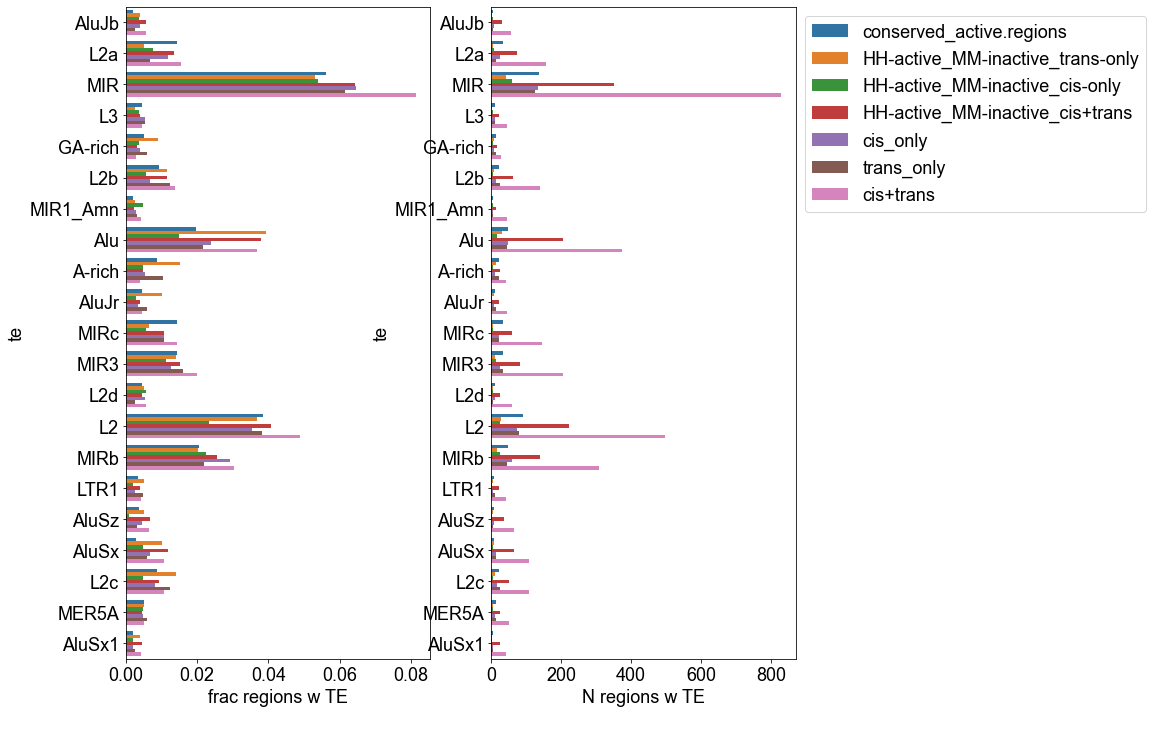

In [49]:
##### 

x="frac"
y="te"
hue = "activity_cat"
data = all_te_enrichment
fig, (ax1, ax2) = plt.subplots( ncols = 2, figsize = (12,12))
sns.barplot(x=x, y=y, data=data, hue=hue, ax = ax1)
ax1.legend(bbox_to_anchor = (1,1)).remove()
ax1.set(xlabel = "frac regions w TE")

#ax2 = ax1.twiny()
x="a"
sns.barplot(x=x, y=y, data=data, hue=hue, ax = ax2)
ax2.legend(bbox_to_anchor = (1,1))
ax2.set(xlabel = "N regions w TE\n")

outf = os.path.join(RE, "SharedACC_HH_isActive_TE_20220411.pdf")
#plt.savefig(outf, bbox_inches = "tight")